# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder 

In [0]:
import os
os.chdir('/content/drive/My Drive/Face_Detection')
path = '.'


In [5]:
ls

images.npy


### Load the "images.npy" file 
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  

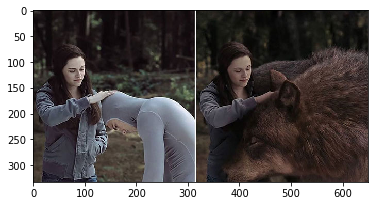

In [7]:
import matplotlib.pyplot as plt
plt.imshow(data[0][0])

### Set image dimensions   
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  

In [69]:
print("Shape of X_train",X_train.shape)
print("Shape of mask",masks.shape)

Shape of X_train (409, 224, 224, 3)
Shape of mask (409, 224, 224)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

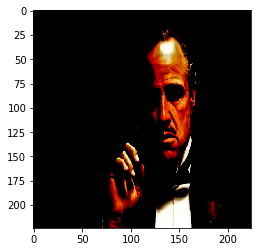

In [11]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

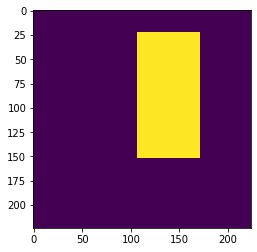

In [12]:
pyplot.imshow(masks[n])

## Create the model 
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
HEIGHT_CELLS = 224
WIDTH_CELLS = 224


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
        block4 = model.get_layer("conv_pw_1_relu").output
        block5 = model.get_layer("conv_pw_3_relu").output
        block1 = model.get_layer("conv_pw_5_relu").output
        block2 = model.get_layer("conv_pw_11_relu").output
        block3 = model.get_layer("conv_pw_13_relu").output

        x = Concatenate()([UpSampling2D()(block3), block2])
        x = Concatenate()([UpSampling2D()(x), block1])
        x = Concatenate()([UpSampling2D()(x), block5])
        x = Concatenate()([UpSampling2D()(x), block4])
        x = UpSampling2D()(x)
        x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
        x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [42]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function
- Create a function to calculate dice coefficient


In [0]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model 
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model 
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [48]:
model.fit(X_train,masks,epochs=12,batch_size=1,callbacks=[checkpoint, reduce_lr, stop])

Train on 409 samples
Epoch 1/12
408/409 [============================>.] - ETA: 0s - loss: 0.6159 - dice_coefficient: 0.6796
Epoch 00001: loss improved from 0.80693 to 0.61520, saving model to model-0.62.h5
409/409 [==============================] - 46s 112ms/sample - loss: 0.6152 - dice_coefficient: 0.6798
Epoch 2/12
408/409 [============================>.] - ETA: 0s - loss: 0.5591 - dice_coefficient: 0.7019
Epoch 00002: loss improved from 0.61520 to 0.55911, saving model to model-0.56.h5
409/409 [==============================] - 46s 113ms/sample - loss: 0.5591 - dice_coefficient: 0.7017
Epoch 3/12
408/409 [============================>.] - ETA: 0s - loss: 0.5099 - dice_coefficient: 0.7242
Epoch 00003: loss improved from 0.55911 to 0.51015, saving model to model-0.51.h5
409/409 [==============================] - 46s 112ms/sample - loss: 0.5102 - dice_coefficient: 0.7239
Epoch 4/12
408/409 [============================>.] - ETA: 0s - loss: 0.4934 - dice_coefficient: 0.7318
Epoch 00004

### Get the predicted mask for a sample image 

In [0]:
WEIGHTS_FILE = "model-0.39.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


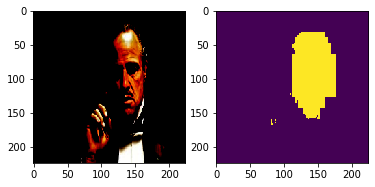

In [71]:
n = 10
sample_image = X_train[n]
resized_image = np.expand_dims(sample_image, axis=0)
region = 1.0*(model.predict(resized_image)>0.5)
#### Add your code here ####
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X_train[n])
axarr[1].imshow(region[0])


### Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


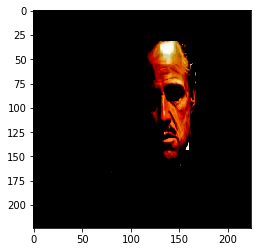

In [72]:
image2 = X_train[n]
image2[:,:,0] = region*X_train[n][:,:,0]
image2[:,:,1] = region*X_train[n][:,:,1]
image2[:,:,2] = region*X_train[n][:,:,2]

out_image = image2
pyplot.imshow(out_image)